首先我们引入本案例需要的所有模块

In [1]:
# 引入需要的模块
import os
import zipfile
import random
import json
import paddle
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from paddle.io import Dataset
random.seed(200)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matp

接下来我们正式开始数据集的预处理，第一步我们使用zipfile模块来解压原始数据集，将src_path路径下的zip包解压至target_path目录下

In [2]:
def unzip_data(src_path,target_path):
    if(not os.path.isdir(target_path + "shenghuo")):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()

第二步我们按照7:1的比例划分训练集与验证集，之后打乱数据集的顺序并生成数据列表

In [3]:
def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path+"shenghuo/"
    class_dirs = os.listdir(data_list_path)  
    #总的图像数量
    all_class_images = 0
    #存放类别标签
    class_label=0
    #存放类别数目
    class_dim = 0
    #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    #读取每个类别，['baihe', 'gouqi','jinyinhua','huaihua','dangshen']
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径 
            path = data_list_path  + class_dir
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:                                  # 遍历文件夹下的每个图片
                name_path = path + '/' + img_path                       # 每张图片的路径
                if class_sum % 8 == 0:                                  # 每8张图片取一个做验证数据
                    eval_sum += 1                                       # test_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                else:
                    trainer_sum += 1 
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                class_sum += 1                                          #每类图片的数目
                all_class_images += 1                                   #所有类图片的数目
             
            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称
            class_detail_list['class_label'] = class_label          #类别标签
            class_detail_list['class_eval_images'] = eval_sum       #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
            class_detail.append(class_detail_list)  
            #初始化标签列表
            train_parameters['label_dict'][str(class_label)] = class_dir
            class_label += 1 
            
    #初始化分类数
    train_parameters['class_dim'] = class_dim
  
    #乱序  
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
            
    random.shuffle(trainer_list)
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image) 

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'],'w') as f:
        f.write(jsons)
    print ('生成数据列表完成！')

当然，我们目前只是定义了以上两个函数，要想完成上述两个步骤，我们需要初始化数据集存取存放路径，调用上述解压数据集函数与生成数据列表函数完成读入数据之前的准备工作

In [4]:
train_parameters = {
    "src_path":"/home/aistudio/work/shenghuo.zip",    #原始数据集路径
    "target_path":"/home/aistudio/work/",                     #要解压的路径
    "train_list_path": "/home/aistudio/work/train.txt",       #train.txt路径
    "eval_list_path": "/home/aistudio/work/eval.txt",         #eval.txt路径
    "label_dict":{},                                          #标签字典
    "readme_path": "/home/aistudio/work/readme.json",         #readme.json路径
    "class_dim": -1,                                          #分类数
}
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']

# 调用解压函数解压数据集
unzip_data(src_path,target_path)


# 划分训练集与验证集，乱序，生成数据列表
#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

生成数据列表完成！


数据预处理的最后一步是定义数据读取器并将图片转为RGB格式，数据维度由(H, W, C)转为(C, H, W)，图片大小resize为224 * 224用于训练

In [5]:
# 定义数据读取器
class dataset(Dataset):
    def __init__(self, data_path, mode='train'):
        """
        数据读取器
        :param data_path: 数据集所在路径
        :param mode: train or eval
        """
        super().__init__()
        self.data_path = data_path
        self.img_paths = []
        self.labels = []

        if mode == 'train':
            with open(os.path.join(self.data_path, "train.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))

        else:
            with open(os.path.join(self.data_path, "eval.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))


    def __getitem__(self, index):
        """
        获取一组数据
        :param index: 文件索引号
        :return:
        """
        # 第一步打开图像文件并获取label值
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB') 
        img = img.resize((224, 224), Image.BILINEAR)
        #img = rand_flip_image(img)
        img = np.array(img).astype('float32')
        img = img.transpose((2, 0, 1)) / 255
        label = self.labels[index]
        label = np.array([label], dtype="int64")
        return img, label

    def print_sample(self, index: int = 0):
        print("文件名", self.img_paths[index], "\t标签值", self.labels[index])

    def __len__(self):
        return len(self.img_paths)

同样我们需要调用上面定义的数据读取器来读入训练数据和评估数据，这里我们使用paddle.io.DataLoader模块实现数据加载，并且指定训练集批大小batch_size为32，乱序读入；验证集批大小为8，不打乱顺序。对于训练集批大小的选择，我们会在后续的模型优化章节为大家详细解读。

In [6]:
#训练数据加载
train_dataset = dataset('/home/aistudio/work',mode='train')
train_loader = paddle.io.DataLoader(train_dataset, batch_size=32, shuffle=True)
#评估数据加载
eval_dataset = dataset('/home/aistudio/work',mode='eval')
eval_loader = paddle.io.DataLoader(eval_dataset, batch_size = 8, shuffle=False)

由上述结构图可知，我们可以把VGG的每组卷积+池化的操作提炼成一个模块，我们将连续的卷积数设为一个参数groups，将groups个卷积层加reLU层与模块最后的Maxpool层进行拼接

In [7]:
# 定义卷积池化网络
class ConvPool(paddle.nn.Layer):
    '''卷积+池化'''
    def __init__(self,
                 num_channels,
                 num_filters, 
                 filter_size,
                 pool_size,
                 pool_stride,
                 groups,
                 conv_stride=1, 
                 conv_padding=1,
                 ):
        super(ConvPool, self).__init__()  

        # groups代表卷积层的数量
        for i in range(groups):
            self.add_sublayer(   #添加子层实例
                'bb_%d' % i,
                paddle.nn.Conv2D(         # layer
                in_channels=num_channels, #通道数
                out_channels=num_filters,   #卷积核个数
                kernel_size=filter_size,   #卷积核大小
                stride=conv_stride,        #步长
                padding = conv_padding,    #padding
                )
            )
            self.add_sublayer(
                'relu%d' % i,
                paddle.nn.ReLU()
            )
            num_channels = num_filters
            

        self.add_sublayer(
            'Maxpool',
            paddle.nn.MaxPool2D(
            kernel_size=pool_size,           #池化核大小
            stride=pool_stride               #池化步长
            )
        )

    def forward(self, inputs):
        x = inputs
        for prefix, sub_layer in self.named_children():
            # print(prefix,sub_layer)
            x = sub_layer(x)
        return x
        

接下来我们根据上述模块构建VGG网络，VGG网络由groups分别为2，2，3，3，3的5个ConvPool模块还有三个全连接层组成，全连接层之间使用dropout层防止过拟合。

In [8]:
# VGG网络
class VGGNet(paddle.nn.Layer):
    def __init__(self):
        super(VGGNet, self).__init__()       
        # 5个卷积池化操作
        self.convpool01 = ConvPool(
            3, 64, 3, 2, 2, 2)  #3:通道数，64：卷积核个数，3:卷积核大小，2:池化核大小，2:池化步长，2:连续卷积个数
        self.convpool02 = ConvPool(
            64, 128, 3, 2, 2, 2)
        self.convpool03 = ConvPool(
            128, 256, 3, 2, 2, 3) 
        self.convpool04 = ConvPool(
            256, 512, 3, 2, 2, 3)
        self.convpool05 = ConvPool(
            512, 512, 3, 2, 2, 3)       
        self.pool_5_shape = 512 * 7* 7
        # 三个全连接层
        self.fc01 = paddle.nn.Linear(self.pool_5_shape, 4096)
        self.drop1 = paddle.nn.Dropout(p=0.5)
        self.fc02 = paddle.nn.Linear(4096, 4096)
        self.drop2 = paddle.nn.Dropout(p=0.5)
        self.fc03 = paddle.nn.Linear(4096, train_parameters['class_dim'])

    def forward(self, inputs, label=None):
        # print('input_shape:', inputs.shape) #[8, 3, 224, 224]
        """前向计算"""
        out = self.convpool01(inputs)
        # print('convpool01_shape:', out.shape)           #[8, 64, 112, 112]
        out = self.convpool02(out)
        # print('convpool02_shape:', out.shape)           #[8, 128, 56, 56]
        out = self.convpool03(out)
        # print('convpool03_shape:', out.shape)           #[8, 256, 28, 28]
        out = self.convpool04(out)
        # print('convpool04_shape:', out.shape)           #[8, 512, 14, 14]
        out = self.convpool05(out)
        # print('convpool05_shape:', out.shape)           #[8, 512, 7, 7]         

        out = paddle.reshape(out, shape=[-1, 512*7*7])
        out = self.fc01(out)
        out = self.drop1(out)
        out = self.fc02(out)
        out = self.drop2(out)
        out = self.fc03(out)
        
        if label is not None:
            acc = paddle.metric.accuracy(input=out, label=label)
            return out, acc
        else:
            return out
            

# **5.训练配置** 
本案例中，我们使用Adam优化器，2014年12月，Kingma和Lei Ba提出了Adam优化器。该优化器对梯度的均值，即一阶矩估计（First Moment Estimation）和梯度的未中心化的方差，即二阶矩估计（Second Moment Estimation）进行综合计算，获得更新步长。Adam优化器实现起来较为简单，且计算效率高，需要的内存更少，梯度的伸缩变换不会影响更新梯度的过程， 超参数的可解释性强，且通常超参数无需调整或仅需微调。我们将学习率设置为0.0001，训练35个epochs。

为了更直观的看到训练过程中的loss和acc变化趋势，我们首先写一下用于画出折线图的函数

In [9]:
# 折线图，用于观察训练过程中loss和acc的走势
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

接下来我们更新一下train_parameters，，在之前的基础上加入训练模型需要的参数，包括
- 输入图片的shape
- 训练轮数
- 训练时输出日志的迭代间隔
- 训练时保存模型参数的迭代间隔
- 优化函数的学习率
- 保存的路径

In [10]:
# 参数配置，要保留之前数据集准备阶段配置的参数，所以使用update更新字典
train_parameters.update({
    "input_size": [3, 224, 224],                              #输入图片的shape
    "num_epochs": 35,                                         #训练轮数
    "skip_steps": 10,                                         #训练时输出日志的间隔
    "save_steps": 100,                                         #训练时保存模型参数的间隔
    "learning_strategy": {                                    #优化函数相关的配置
        "lr": 0.0001                                          #超参数学习率
    },
    "checkpoints": "/home/aistudio/work/checkpoints"          #保存的路径
})

# 6.模型训练
现在我们开始训练模型，训练步骤如下：
- 模型实例化
- 配置loss函数
- 配置参数优化器
- 开始训练，每经过skip_step打印一次日志，每经过save_step保存一次模型
- 训练完成后画出loss和acc变化图

In [12]:
from paddle.static import InputSpec
model = VGGNet()
model.train()
# 配置loss函数
cross_entropy = paddle.nn.CrossEntropyLoss()
# 配置参数优化器
optimizer = paddle.optimizer.Adam(learning_rate=train_parameters['learning_strategy']['lr'],
                                  parameters=model.parameters()) 

steps = 0
Iters, total_loss, total_acc = [], [], []

for epo in range(train_parameters['num_epochs']):
    for _, data in enumerate(train_loader()):
        steps += 1
        x_data = data[0]
        y_data = data[1]
        predicts, acc = model(x_data, y_data)
        loss = cross_entropy(predicts, y_data)
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
        if steps % train_parameters["skip_steps"] == 0:
            Iters.append(steps)
            total_loss.append(loss.numpy()[0])
            total_acc.append(acc.numpy()[0])
            #打印中间过程
            print('epo: {}, step: {}, loss is: {}, acc is: {}'\
                  .format(epo, steps, loss.numpy(), acc.numpy()))
        #保存模型参数
        if steps % train_parameters["save_steps"] == 0:
            save_path = train_parameters["checkpoints"]+"/"+"save_dir_" + str(steps) + '.pdparams'
            print('save model to: ' + save_path)
            paddle.save(model.state_dict(),save_path)

        
paddle.save(model.state_dict(),train_parameters["checkpoints"]+"/"+"save_dir_final.pdparams")
draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
draw_process("trainning acc","green",Iters,total_acc,"trainning acc")

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and


ValueError: In transformed code:

    File "/tmp/ipykernel_996/1699360416.py", line 27, in forward (* user code *)
	out = self.convpool01(inputs)
    File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py", line 902, in __call__
	outputs = self.forward(*inputs, **kwargs)
    File "/tmp/ipykernel_996/533939682.py", line 47, in forward (* user code *)
	x = sub_layer(x)
    File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py", line 902, in __call__
	outputs = self.forward(*inputs, **kwargs)
    File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/conv.py", line 660, in forward
	use_cudnn=self._use_cudnn)
    File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/functional/conv.py", line 144, in _conv_nd
	type=op_type, inputs=inputs, outputs=outputs, attrs=attrs)
    File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layer_helper.py", line 43, in append_op
	return self.main_program.current_block().append_op(*args, **kwargs)
    File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/framework.py", line 3027, in append_op
	attrs=kwargs.get("attrs", None))
    File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/framework.py", line 2222, in __init__
	self.desc.infer_shape(self.block.desc)
    ValueError: (InvalidArgument) The input of Op(Conv) should be a 4-D or 5-D Tensor. But received: input's dimension is 3, input's shape is [3, 224, 224].
  [Hint: Expected in_dims.size() == 4 || in_dims.size() == 5 == true, but received in_dims.size() == 4 || in_dims.size() == 5:0 != true:1.] (at /paddle/paddle/fluid/operators/conv_op.cc:61)
  [operator < conv2d > error]

# **7.模型优化**
**改变batch_size优化模型**

batch_size指的是一次训练所选取的样本数。

在网络训练过程中，batch_size过大或者过小都会影响训练的性能和速度，batch_size过小，花费时间多，同时梯度震荡严重，不利于收敛；batch_size过大，不同batch的梯度方向没有任何变化，容易陷入局部极小值。

例如，在本案例中，我们直接使用神经网络通常设置的```batch_size=16```，训练35个epochs之后模型在验证集上的准确率为： 0.825

在合理范围内，增大batch_size会提高显存的利用率，提高大矩阵乘法的并行化效率，减少每个epoch需要训练的迭代次数。在一定范围内，batch size越大，其确定的下降方向越准，引起训练时准确率震荡越小。  

在本案例中，我们设置```batch_size=32```，同样训练35个epochs，模型在验证集上的准确率为： 0.842

当然，过大的batch_size同样会降低模型性能。

在本案例中，我们设置`batch_size=48`，训练35个epochs之后模型在验证集上的准确率为： 0.817

从以上的实验结果对比中，我们可以清楚的了解到，在模型优化的过程中，找到合适的batch_size是很重要的。

# **8.模型评估**

我们使用验证集来评估训练过程保存的最后一个模型，首先加载模型参数，之后遍历验证集进行预测并输出平均准确率

In [ ]:
# 模型评估
# 加载训练过程保存的最后一个模型
model__state_dict = paddle.load('work/checkpoints/save_dir_final.pdparams')
model_eval = VGGNet()
model_eval.set_state_dict(model__state_dict) 
model_eval.eval()
accs = []
# 开始评估
for _, data in enumerate(eval_loader()):
    x_data = data[0]
    y_data = data[1]
    predicts = model_eval(x_data)
    acc = paddle.metric.accuracy(predicts, y_data)
    accs.append(acc.numpy()[0])
print('模型在验证集上的准确率为：',np.mean(accs))

模型在验证集上的准确率为： 0.98


# **9.模型推理**
采用与训练过程同样的图片转换方式对测试集图片进行预处理

In [ ]:
def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path) 
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((224, 224), Image.BILINEAR)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1)) / 255 # HWC to CHW 及归一化
    return img


label_dic = train_parameters['label_dict']
label_dic

{'0': 'dryer', '1': 'power', '2': 'watch'}

我们使用训练过程保存的最后一个模型预测测试集中的图片，首先加载模型，预测并输出每张图片的预测值

样本: baihe.jpg,被预测为:power


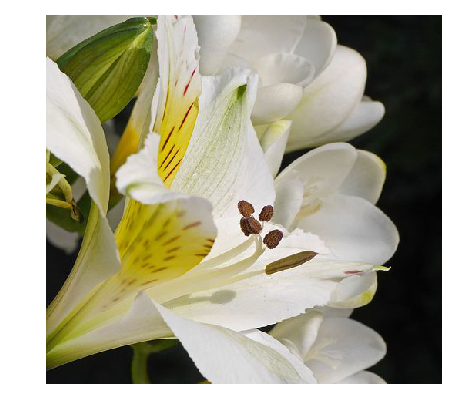

样本: gouqi.jpg,被预测为:dryer


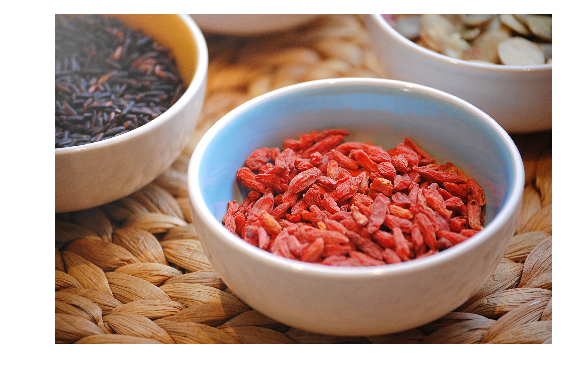

样本: jinyinhua.jpg,被预测为:watch


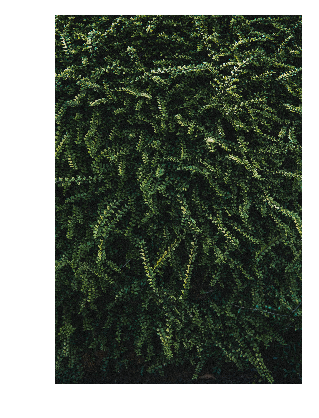

In [ ]:
import time
# 加载训练过程保存的最后一个模型
model__state_dict = paddle.load('work/checkpoints/save_dir_final.pdparams')
model_predict = VGGNet()
model_predict.set_state_dict(model__state_dict) 
model_predict.eval()
infer_imgs_path = os.listdir("infer")
# print(infer_imgs_path)

# 预测所有图片
for infer_img_path in infer_imgs_path:
    infer_img = load_image("infer/"+infer_img_path)
    infer_img = infer_img[np.newaxis,:, : ,:]  #reshape(-1,3,224,224)
    infer_img = paddle.to_tensor(infer_img)
    result = model_predict(infer_img)
    lab = np.argmax(result.numpy())
    print("样本: {},被预测为:{}".format(infer_img_path,label_dic[str(lab)]))
    img = Image.open("infer/"+infer_img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    sys.stdout.flush()
    time.sleep(0.5)

# **10.模型部署**
模型基于飞桨框架实现，具体部署过程可以参考[飞桨官方文档的推理部署教程](https://www.paddlepaddle.org.cn/documentation/docs/zh/guides/05_inference_deployment/index_cn.html/?fr=paddleEdu_aistudio)

# **资源**

更多资源请参考：

* 更多深度学习知识、产业案例，请参考：[awesome-DeepLearning](https://github.com/paddlepaddle/awesome-DeepLearning)

* 更多图像分类模型(ResNet_vd系列、MobileNet_v3等)，请参考：[PaddleClas](https://github.com/PaddlePaddle/PaddleClas)

* 飞桨框架相关资料，请参考：[飞桨深度学习平台](https://www.paddlepaddle.org.cn/?fr=paddleEdu_aistudio)

<br/>

<font size=5>**数据来源**</font>

<br/>

#### 本案例数据集来源于：https://aistudio.baidu.com/aistudio/datasetdetail/55190

#### 此项目参考开发者 国科大师资培训 的 中草药识别-2.0版本 项目，原项目地址为https://aistudio.baidu.com/aistudio/projectdetail/1434738?channelType=0&channel=0